In [4]:
import entailment as ent
from entailment import led_parser

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import copy
import random


## Baselines

Want to implement some better baselines.

How much better this the `possibleworldsnet` than just evaluating entailment over possible worlds...
- what does the cts sat approximation actually achieve?
- how much of `possibleworldsnet`'s performance is due to the possible worlds?

In [5]:
gen = ent.data.fetch_data(500)

In [6]:
class Evaluator():
    def __init__(self):
        self.alphabet = 'abcdefghijklmnopqrstuvwxyz'
        language = led_parser.propositional_language()
        self.parser = led_parser.Parser(language)
        self.build_op_mappings()
        
    def build_op_mappings(self):
        mapping = {}
        mapping['&'] = bool.__and__
        mapping['~'] = lambda x: not x # bool.__neg__
        mapping['|'] = bool.__or__
        mapping['<'] = bool.__le__
        mapping['>'] = bool.__ge__
        
        self.op_mappings = mapping
        
    def rnd_assignment(self):
        return {c: bool(random.getrandbits(1)) for c in self.alphabet}
        
    def __call__(self, s, assignments=None):
        if assignments is None:
            assignments = self.rnd_assignment()
        
        tree = self.parser.parse(s)

        stack = []
        for i in range(len(tree.inputs)):
            
            if len(tree.inputs[i]) == 0:
                stack.append(assignments[tree.ops[i].decode("utf-8")])
                
            elif len(tree.inputs[i]) == 1:
                idx = tree.inputs[i][0] + i
                fn = self.op_mappings[tree.ops[i].decode("utf-8")]
                stack.append(fn(stack[idx]))
                
            elif len(tree.inputs[i]) == 2:
                idx = [idx + i for idx in tree.inputs[i]]
                fn = self.op_mappings[tree.ops[i].decode("utf-8")]
                stack.append(fn(stack[idx[0]], stack[idx[1]]))
                
        return stack[-1]

evaluator = Evaluator()

In [7]:
A, B, E = next(gen)

In [8]:
def sim_world(a, b):
    # TODO make this a fn of a, b
    world = evaluator.rnd_assignment()

    e_a = evaluator(a, world)  
    e_b = evaluator(b, world)

    p = 1.0
    if e_a and e_b:
        return 1.0
    elif e_a and not e_b:
        return 0.0
    elif not e_a and e_b:
        return 1.0
    elif not e_a and not e_b:
        return 1.0
    else:
        return np.random.randint(0, 2, dtype=np.int32).astype(np.float32)
    
def many_worlds(a, b, n_worlds):
    y = [sim_world(a, b) for _ in range(n_worlds)]
    return np.prod(y)

In [9]:
print(A[0], B[0])
many_worlds(A[0], B[0], 10)

(z&((x&w)&l)) (w&~(~((g>z))))


0.0

In [10]:
# SLOW
# y = np.array([many_worlds(a, b, 8) for a, b in zip(A, B)])  # can be parallelised!
# acc = np.mean(np.equal(y, np.array(E)))
# print('acc {}'.format(acc))

In [11]:
acc = np.mean(np.equal(np.random.randint(0, 2, len(E)), np.array(E)))
print('acc {}'.format(acc))

acc 0.516


In [12]:
from multiprocessing import Pool
from functools import partial

In [13]:
def wrapper(x, n_worlds):
    a, b = x
    return many_worlds(a, b, n_worlds)

def forward(A, B, n_worlds):
    f = partial(wrapper, n_worlds=n_worlds)
    with Pool(16) as p:
        y = p.map(f, zip(A, B))
    return y

In [14]:
%timeit forward(A, B, 10)

11.3 s ± 472 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit [many_worlds(a, b, 10) for a, b in zip(A, B)]

20.5 s ± 261 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
acc = []
world_sizes = [8, 16, 32, 64, 128, 256, 512]
for n_worlds in world_sizes:
    y = np.array(forward(A, B, n_worlds))
    acc.append(np.mean(np.equal(y, np.array(E))))
    print('acc {}'.format(acc[-1]))

acc 0.542
acc 0.576
acc 0.6
acc 0.624
acc 0.622
acc 0.628
acc 0.63


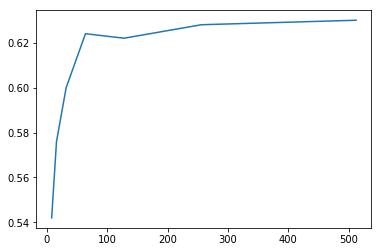

In [17]:
plt.plot(world_sizes, acc)

In [ ]:
# so accuracy scales really poorly with n_worlds!?

## Searching through assignments

There are $2^{26}$ different variable assignments. Sample $n$ of them and test.
What guarantees can we prove?
How likely is it that $a \rightarrow b$ given only few samples. 

But each $a, b$ doesnt have $26$ variables in it, normally only $3-8$. So this should be easy to earch thruogh the possibilities? $2^8 = 256$.

Want something that scales well with !?.

What about representing a distribution over the worlds we should test?! Let $a$ be an assignment, and $s$ be an input string. $f: s \rightarrow p(a)$. But how can we efficiently represent a distribution over $2^{26}$ assignments? Use a tensor network!?